In [14]:
from google.colab import files
uploaded = files.upload()

Saving cipdataset.csv to cipdataset (1).csv


In [15]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from wordcloud import WordCloud
import re
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,f1_score

In [16]:
data = pd.read_csv("cipdataset.csv")

In [17]:
data.head()

,Unnamed: 0,Unnamed: 0.1,created_at,tweet_id,receiver_name,receiver_id,tweet_text,screen_name,name,account_creation_date,urls,preprocess_tweet,Positive,Negative,Compound,Sentiment,label
0,0,0,2022-04-25 17:10:41+00:00,1518638641848803329,NaN,NaN,rt @wckitchen: scenes from our food kit delive...,joelleshay1,@Joellimoguy,Fri Mar 31 05:40:07 +0000 2017,[],scenes food kit delivery umlazi south africa w...,0.318,0.000,0.6808,Positive,1
1,1,1,2022-04-25 17:10:38+00:00,1518638627923894274,NaN,NaN,"public health experts, juno thomas and linda e...",SABCNews,SABC News,Wed Mar 18 15:16:33 +0000 2009,"[{'url': 'https://t.co/EE5xDNmv7q', 'expanded_...",public health expes juno thomas linda erasmus ...,0.000,0.000,0.0000,Negative,0
2,2,2,2022-04-25 17:10:37+00:00,1518638624849412096,NaN,NaN,rt @_bonga: kzn revised the cost of the floods...,_RebaS,Reba,Sun Nov 23 15:31:45 +0000 2014,[],kzn revised cost floods r bn r bn,0.000,0.000,0.0000,Negative,0
3,3,3,2022-04-25 17:10:24+00:00,1518638571049078784,NaN,NaN,mdmema: even if you don’t live next to a water...,BlueCrabsFoodFe,Blue Crabs Beer Food & Wine Fest,Fri Feb 16 20:37:12 +0000 2018,"[{'url': 'https://t.co/qZkYMJ183I', 'expanded_...",mdmema even live next water source small amoun...,0.000,0.134,-0.1779,Negative,0
4,4,4,2022-04-25 17:10:09+00:00,1518638508201881600,NaN,NaN,rt @amydoghouse: @elonmusk @johnnacrider1 @sta...,albertw73935497,Albert J. Wallace,Mon May 11 12:41:54 +0000 2020,[],right subways completely sealed water flow h,0.000,0.000,0.0000,Negative,0


In [ ]:
print(data["label"].value_counts())

0    390
1    111
Name: label, dtype: int64


In [18]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional,Flatten,Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [19]:
data['preprocess_tweet']= data['preprocess_tweet'].astype(str)

In [20]:
tokenizer = Tokenizer(num_words=5000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
tokenizer.fit_on_texts(data["preprocess_tweet"])
X = tokenizer.texts_to_sequences(data["preprocess_tweet"])
X = pad_sequences(X,maxlen=500)
Y = data["label"]
vocab_size = len(tokenizer.word_index) + 1
# We can then create our train and test sets:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 24)
#We store this tokenizer in a file to use later in web app
import pickle
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
from sklearn.preprocessing import LabelEncoder


In [21]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=500))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 50)           92900     
                                                                 
 lstm_2 (LSTM)               (None, 128)               91648     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 184,677
Trainable params: 184,677
Non-trainable params: 0
_________________________________________________________________


In [23]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

In [24]:
oversample = RandomOverSampler(sampling_strategy='minority')

In [25]:
X_over, Y_over = oversample.fit_resample(X_train, Y_train)

In [26]:
def prepare_targets(Y_over, y_test):
 le = LabelEncoder()
 le.fit(Y_over)
 y_train_enc = le.transform(Y_over)
 y_test_enc = le.transform(y_test)
 return y_train_enc, y_test_enc
ytrain,ytest = prepare_targets(Y_over,Y_test)

In [27]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history=model.fit(X_over, ytrain,
 batch_size=128,
 epochs=10,
 validation_data=[X_test, ytest],
 callbacks=[es])

Epoch 1/10
5/5 [==============================] - 12s 2s/step - loss: 0.6918 - accuracy: 0.4833 - val_loss: 0.6782 - val_accuracy: 0.8013
Epoch 2/10
5/5 [==============================] - 14s 3s/step - loss: 0.6838 - accuracy: 0.6227 - val_loss: 0.6616 - val_accuracy: 0.8344
Epoch 3/10
5/5 [==============================] - 8s 2s/step - loss: 0.6658 - accuracy: 0.7807 - val_loss: 0.6354 - val_accuracy: 0.8411
Epoch 4/10
5/5 [==============================] - 8s 2s/step - loss: 0.6193 - accuracy: 0.8197 - val_loss: 0.5759 - val_accuracy: 0.8146
Epoch 5/10
5/5 [==============================] - 12s 2s/step - loss: 0.5792 - accuracy: 0.7825 - val_loss: 0.6227 - val_accuracy: 0.6225
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 0.5248 - accuracy: 0.7416 - val_loss: 0.7463 - val_accuracy: 0.3907
Epoch 7/10
5/5 [==============================] - 8s 2s/step - loss: 0.5340 - accuracy: 0.6636 - val_loss: 0.7353 - val_accuracy: 0.3841
Epoch 8/10
5/5 [======================

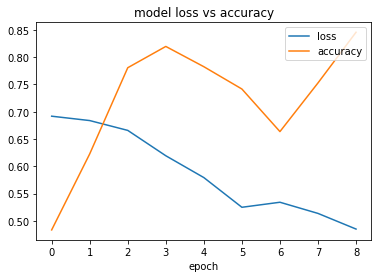

In [28]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['accuracy'])
pyplot.title('model loss vs accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'accuracy'], loc='upper right')
pyplot.show()

In [33]:
string11='''Between the bitch bitch bullshit shit bitch bitch shit bullshit cyberbully overtones and Liberato’s performance, 
The Beach House offers up terror and will make you think before opening your door.'''
x_1=tokenizer.texts_to_sequences([string11])
x_1 = pad_sequences(x_1,maxlen=500)
model.predict(x_1)

array([[0.45605716]], dtype=float32)